# EDA, NLP and Modeling

## Imports

In [432]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import recall_score, accuracy_score, SCORERS
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [82]:
pd.set_option('display.max_rows', 500)

## Data Import

In [586]:
df = pd.read_csv('../data/data.csv')

In [587]:
df.sample(5)

,title,selftext,comments,label
382,Stroke survivor opinions?,February 2018 my dad had the symptoms of a str...,I lost use of my left arm when I was very youn...,1
3222,Over 4 years Migraine free,It was just over 4.5 years since I had my last...,What have you done to get rid of them? I’d lik...,0
2845,Getting an MRI for my migraines,My doctor scheduled an MRI for me after we tal...,"It’s loud and annoying, so I try to just lay t...",0
4227,Emotional news trigger,"90 days migraine-free, then today (an admitted...",Absolutely. I have terrible anxiety and anythi...,0
2277,Any food triggers for silent migraines? Or jus...,I think for me high carbs maybe does it but i ...,Chocolate sometimes and Red wine as a hundred ...,0


In [590]:
df['label'].value_counts()

0    4239
1     980
Name: label, dtype: int64

## Exploratory Data Analysis

Check for nulls and replace nulls in comments with spaces because they are going to be added to the corresponding posts.

In [36]:
df.isnull().sum()

title         0
selftext      3
comments    457
label         0
dtype: int64

In [37]:
df.drop(df[df["selftext"].isnull()].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [38]:
df.replace({np.NaN : ' '}, inplace=True)

In [39]:
df.isnull().sum().sum()

0

In [40]:
df.dtypes

title       object
selftext    object
comments    object
label        int64
dtype: object

Create two input('X') series, one with only the title and post and another with the comments added.

Create series for target 'y'

In [41]:
X_post = df['title'] + ' ' + df['selftext']
X_post_comm = df['title'] + ' ' + df['selftext'] + ' ' + df['comments']
y = df['label']

#### Stats for the number of words in each subreddit post and comments

In [243]:
# word ratio for both subreddits:
tokenizer = RegexpTokenizer('(?u)\\b\\w\\w+\\b')
X_post_token = []
X_post_comm_token = []

for i in range(len(X_post)):
    tp = tokenizer.tokenize(X_post[i])
    tpc = tokenizer.tokenize(X_post_comm[i])
    X_post_token.append(tp)
    X_post_comm_token.append(tpc)
    
len_p_stroke = []
len_p_migraine = []
len_pc_stroke = []
len_pc_migraine = []

for i,v in enumerate(y):
    lp = len(X_post_token[i])
    lpc = len(X_post_comm_token[i])
    if v:
        len_p_stroke.append(lp)
        len_pc_stroke.append(lpc)
        
    else:
        len_p_migraine.append(lp)
        len_pc_migraine.append(lpc)
        
print(f'Average no. of words per POST in r/stroke: {np.mean(len_p_stroke)}')
print(f'Average no. of words per POST in r/migraine: {np.mean(len_p_migraine)}')
print(f'Median no. of words per POST in r/stroke: {np.median(len_p_stroke)}')
print(f'Median no. of words per POST in r/migraine: {np.median(len_p_migraine)}\n')

print(f'Average no. of words per POST+COMMENT in r/stroke: {np.mean(len_pc_stroke)}')
print(f'Average no. of words per POST+COMMENT in r/migraine: {np.mean(len_pc_migraine)}')
print(f'Median no. of words per POST+COMMENT in r/stroke: {np.median(len_pc_stroke)}')
print(f'Median no. of words per POST+COMMENT in r/migraine: {np.median(len_pc_migraine)}')

Average no. of words per POST in r/stroke: 192.68577277379734
Average no. of words per POST in r/migraine: 123.40268931351734
Median no. of words per POST in r/stroke: 134.0
Median no. of words per POST in r/migraine: 92.0

Average no. of words per POST+COMMENT in r/stroke: 653.6816786079836
Average no. of words per POST+COMMENT in r/migraine: 382.74074074074076
Median no. of words per POST+COMMENT in r/stroke: 419.0
Median no. of words per POST+COMMENT in r/migraine: 257.0


## Natural Language Processing

#### Sentiment analysis of both the subreddits

In [582]:
def intensity(X, y):
    sid = SentimentIntensityAnalyzer()
    
    total_neg_stroke = 0
    total_neu_stroke = 0
    total_pos_stroke = 0
    total_compound_stroke = 0 
    total_count_stroke = 0
    total_neg_migraine = 0
    total_neu_migraine = 0
    total_pos_migraine = 0
    total_compound_migraine = 0 
    total_count_migraine = 0
    
    for i,sentence in enumerate(X_post):
        ss = sid.polarity_scores(sentence)
        if y[i]:
            total_neg_stroke += ss["neg"]
            total_neu_stroke += ss["neu"]
            total_pos_stroke += ss["pos"]
            total_compound_stroke += ss["compound"]
            total_count_stroke += 1
        else:
            total_neg_migraine += ss["neg"]
            total_neu_migraine += ss["neu"]
            total_pos_migraine += ss["pos"]
            total_compound_migraine += ss["compound"]
            total_count_migraine += 1
            
    print(f'Average negative sentiment for stroke: {total_neg_stroke/total_count_stroke}')
    print(f'Average negative sentiment for migraine: {total_neg_migraine/total_count_migraine}')
    print(f'Average positive sentiment for stroke: {total_pos_stroke/total_count_stroke}')
    print(f'Average positive sentiment for migraine: {total_pos_migraine/total_count_migraine}')
    print(f'Average neutral sentiment for stroke: {total_neu_stroke/total_count_stroke}')
    print(f'Average neutral sentiment for migraine: {total_neu_migraine/total_count_migraine}')
    print(f'Average compound sentiment for stroke: {total_compound_stroke/total_count_stroke}')
    print(f'Average compound sentiment for migraine: {total_compound_migraine/total_count_migraine}')

In [583]:
# Sentiment analysis for stroke vs migraine for posts
intensity(X_post, y)

Average negative sentiment for stroke: 0.08297338792221083
Average negative sentiment for migraine: 0.10434725171030922
Average positive sentiment for stroke: 0.1106253838280451
Average positive sentiment for migraine: 0.09288794527011116
Average neutral sentiment for stroke: 0.8063848515864885
Average neutral sentiment for migraine: 0.8027718801604153
Average compound sentiment for stroke: 0.18332364380757393
Average compound sentiment for migraine: -0.09847548950224122


In [584]:
# Sentiment analysis for stroke vs migraine for posts+comments
intensity(X_post_comm, y)

Average negative sentiment for stroke: 0.08297338792221083
Average negative sentiment for migraine: 0.10434725171030922
Average positive sentiment for stroke: 0.1106253838280451
Average positive sentiment for migraine: 0.09288794527011116
Average neutral sentiment for stroke: 0.8063848515864885
Average neutral sentiment for migraine: 0.8027718801604153
Average compound sentiment for stroke: 0.18332364380757393
Average compound sentiment for migraine: -0.09847548950224122


#### Creating stop words and preprocessor functions

In [382]:
# Custom stop words created after checking the most commonly occurring 100 words:

#######################################################################
# tvec = TfidfVectorizer(max_features=None, min_df=0.02,max_df=0.98,
#                        stop_words=stop_stem,
#                        ngram_range=(1,4),
#                        tokenizer= stemmer)

# X_train = tvec.fit_transform(X_train)
# X_test = tvec.transform(X_test)

# feature_names = tvec.get_feature_names()
# dense = X_train.todense()
# denselist = dense.tolist()

# df = pd.DataFrame(denselist, columns=feature_names)

# X_train_df = pd.DataFrame(X_train.toarray(),
#                           columns=tvec.get_feature_names())
# X_test_df = pd.DataFrame(X_test.toarray(),
#                           columns=tvec.get_feature_names())
#######################################################################

custom_stop = ['migraine','migraines','stroke','blood','hemorrhage','aneurysm','ischemic',
               'any''actually','http','www','amp','x200b','said','question','home','story',
               'suggest','answer','house','love','reddit','share','isn','did','didn','don',
               'does','doesn','thank','thanks','research','please']

stop = list(stop_words.ENGLISH_STOP_WORDS) + custom_stop

lemm = WordNetLemmatizer()
stemm = PorterStemmer()

stop_lemm = [lemm.lemmatize(i) for i in stop]
stop_stem = [stemm.stem(i) for i in stop]

stop_dict = {'stop':stop, 'stop_lemm':stop_lemm, 'stop_stem':stop_stem}

# Define Porter stemmer and lemmatizer functions to use in the Vectorizer

def lemmatizer(text):
    tokenizer = RegexpTokenizer('(?u)\\b\\w\\w+\\b')
    tokens = tokenizer.tokenize(text.lower())
    processed = [lemm.lemmatize(i) for i in tokens]
    return processed

def stemmer(text):
    tokenizer = RegexpTokenizer('(?u)\\b\\w\\w+\\b')
    tokens = tokenizer.tokenize(text.lower())
    processed = [stemm.stem(i) for i in tokens]    
    return processed


## Modeling

In [506]:
# Baseline Accuracy
y.value_counts(normalize=True)

0    0.812692
1    0.187308
Name: label, dtype: float64

Baseline accuracy is 81%, which shows us that accuracy is not a good metric for this data since there is class imbalance. Also, we want to optimize for false negatives, since it is more dangerous to mispredict a stroke than a migraine. 'Sensitivity'(Recall) willbe used as a scoring metric for this dataset.

#### Function to find the best parameters for each model using a small portion of the dataset

In [434]:
def find_best_params(X, y, classifier):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.05, stratify=y)

    if classifier == 'logreg':
        pipe = Pipeline([('vec', TfidfVectorizer(max_features=200)),
                         ('mod', LogisticRegression(solver='liblinear'))])
        pipe_params = {
            'vec__min_df': [0.02, 0.01],
            'vec__max_df': [0.98, 0.99],
            'vec__ngram_range': [(1,1),(1,4),(2,2)],
            'vec__stop_words': [stop_lemm, stop_stem, stop],
            'vec__use_idf': [True, False],
            'vec__tokenizer' : [lemmatizer, stemmer, None],
            'mod__penalty' : ['l1','l2'],
            'mod__C' : [0.1,1]
        }
        
    if classifier == 'ranfor':
        pipe = Pipeline([('vec', TfidfVectorizer(max_features=200)),
                         ('mod', RandomForestClassifier())])
        pipe_params = {
            'vec__min_df': [0.02, 0.01],
            'vec__max_df': [0.98, 0.99],
            'vec__ngram_range': [(1,1),(1,4),(2,2)],
            'vec__stop_words': [stop_lemm, stop_stem, stop],
            'vec__use_idf': [True, False],
            'vec__tokenizer' : [lemmatizer, stemmer, None],
            'mod__n_estimators' : [100, 200],
            'mod__max_depth' : [None, 5, 10],
            'mod__max_features' : [None, 'auto']
        }
        
    if classifier == 'mnb':
        pipe = Pipeline([('vec', TfidfVectorizer(max_features=200)),
                         ('mod', MultinomialNB())])
        pipe_params = {
            'vec__min_df': [0.02, 0.01],
            'vec__max_df': [0.98, 0.99],
            'vec__ngram_range': [(1,1),(1,4),(2,2)],
            'vec__stop_words': [stop_lemm, stop_stem, stop],
            'vec__use_idf': [True, False],
            'vec__tokenizer' : [lemmatizer, stemmer, None],
            'mod__alpha' : [0,1],
            'mod__fit_prior' : [True, False]
        }
        
    gs = GridSearchCV(pipe, pipe_params, scoring='recall', cv=3, n_jobs=2)
    gs.fit(X_train, y_train)
    best_params = gs.best_params_
    
    min_df = best_params['vec__min_df']
    max_df = best_params['vec__max_df']
    ngram_range = best_params['vec__ngram_range']
    use_idf = best_params['vec__use_idf']
    tokenizer = best_params['vec__tokenizer']
    print(f'min_df={min_df}')
    print(f'max_df={max_df}')
    print(f'ngram_range={ngram_range}')
    if best_params['vec__stop_words'] == stop:
        print('stop_words=stop')
        words = 'stop'
    elif best_params['vec__stop_words'] == stop_stem:
        print('stop_words=stop_stem')
        words = 'stop_stem'
    elif best_params['vec__stop_words'] == stop_lemm:
        print('stop_words=stop_lemm')
        words = 'stop_lemm'
    print(f'use_idf={use_idf}')
    print(f'tokenizer={tokenizer}')
    stop_words = words
    
    vec_params = (min_df, max_df, ngram_range, use_idf, tokenizer, stop_words)
    
    if classifier == 'logreg':
    
        penalty = best_params['mod__penalty']
        C = best_params['mod__C']
        print(f'penalty={penalty}')
        print(f'C={C}')
        
        mod_params = (penalty, C)
        
    if classifier == 'ranfor':
        
        n_estimators = best_params['mod__n_estimators']
        max_depth = best_params['mod__max_depth']
        max_features = best_params['mod__max_features']
        print(f'n_estimators={n_estimators}')
        print(f'max_depth={max_depth}')
        print(f'max_features={max_features}')

        mod_params = (n_estimators, max_depth, max_features)
    
    if classifier == 'mnb':
        
        alpha = best_params['mod__alpha']
        fit_prior = best_params['mod__fit_prior']
        print(f'alpha={alpha}')
        print(f'fit_prior={fit_prior}')

        mod_params = (alpha, fit_prior)
        
    return vec_params, mod_params

In [343]:
# best parameters for Logistic Regression on "title+post"
log_vec_p, log_mod_p = find_best_params(X_post, y, 'logreg')

/Users/Sruthi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/Sruthi/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyactu', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'hemorrhag', 'henc', 'hereaft', 'herebi', 'hi', 'hous', 'howev', 'hundr', 'inde', 'ischem', 'latterli', 'mani', 'meanwhil', 'migrain', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowhe

min_df=0.02
max_df=0.98
ngram_range=(1, 1)
stop_words=stop
use_idf=False
tokenizer=<function stemmer at 0x1a2cc89598>
penalty=l1
C=1


In [344]:
# best parameters for Logistic Regression on "title+post+comments"
log_vec_p_c, log_mod_p_c = find_best_params(X_post_comm, y, 'logreg')

/Users/Sruthi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/Sruthi/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyactu', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'hemorrhag', 'henc', 'hereaft', 'herebi', 'hi', 'hous', 'howev', 'hundr', 'inde', 'ischem', 'latterli', 'mani', 'meanwhil', 'migrain', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'o

min_df=0.02
max_df=0.98
ngram_range=(1, 1)
stop_words=stop_lemm
use_idf=False
tokenizer=<function stemmer at 0x1a2cc89598>
penalty=l1
C=1


In [353]:
# best parameters for Random Forests on "title+post"
ran_vec_p, ran_mod_p = find_best_params(X_post, y, 'ranfor')

/Users/Sruthi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/Sruthi/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyactu', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'hemorrhag', 'henc', 'hereaft', 'herebi', 'hi', 'hous', 'howev', 'hundr', 'inde', 'ischem', 'latterli', 'mani', 'meanwhil', 'migrain', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowhe

min_df=0.01
max_df=0.98
ngram_range=(1, 4)
stop_words=stop
use_idf=True
tokenizer=<function stemmer at 0x1a2cc89598>
n_estimators=200
max_depth=5
max_features=None


In [355]:
# best parameters for Random Forests on "title+post+comments"
ran_vec_p_c, ran_mod_p_c = find_best_params(X_post_comm, y, 'ranfor')

/Users/Sruthi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/Sruthi/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyactu', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'hemorrhag', 'henc', 'hereaft', 'herebi', 'hi', 'hous', 'howev', 'hundr', 'inde', 'ischem', 'latterli', 'mani', 'meanwhil', 'migrain', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'o

min_df=0.01
max_df=0.98
ngram_range=(1, 1)
stop_words=stop_lemm
use_idf=False
tokenizer=<function stemmer at 0x1a2cc89598>
n_estimators=100
max_depth=None
max_features=None


In [359]:
# best parameters for Naive Bayes on "title+post"
nb_vec_p, nb_mod_p = find_best_params(X_post, y, 'mnb')

/Users/Sruthi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/Sruthi/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'becau', 'el', 'elsewh', 'everywh', 'hou', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


min_df=0.01
max_df=0.98
ngram_range=(1, 4)
stop_words=stop_stem
use_idf=True
tokenizer=<function stemmer at 0x1a2cc89598>
alpha=1
max_depth=False


In [360]:
# best parameters for Naive Bayes on "title+post+comments"
nb_vec_p_c, nb_mod_p_c = find_best_params(X_post_comm, y, 'mnb')

min_df=0.02
max_df=0.98
ngram_range=(1, 1)
stop_words=stop
use_idf=True
tokenizer=None
alpha=1
max_depth=False


/Users/Sruthi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Function to model the data, extract most important words, plot the ROC-AUC and Predicted probabilities

In [564]:
def classify(X, y, classifier, vec_params, mod_params):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
    print(vec_params, mod_params)
    
    if classifier == 'logreg':
        pipe = Pipeline([('vec', TfidfVectorizer(min_df = vec_params[0],
                                                 max_df = vec_params[1],
                                                 ngram_range = vec_params[2],
                                                 stop_words = stop_stem,
                                                 use_idf = vec_params[3],
                                                 tokenizer = stemmer)),
                         ('mod', LogisticRegression(solver = 'liblinear',
                                                    penalty = mod_params[0],
                                                    C = mod_params[1]))])
    
    if classifier == 'ranfor':
        pipe = Pipeline([('vec', TfidfVectorizer(min_df = vec_params[0],
                                                 max_df = vec_params[1],
                                                 ngram_range = vec_params[2],
                                                 stop_words = stop_stem,
                                                 use_idf = vec_params[4],
                                                 tokenizer = stemmer)),
                         ('mod', RandomForestClassifier(n_estimators = mod_params[0],
                                                        max_depth = mod_params[1],
                                                        max_features = mod_params[2]))])
        
    if classifier == 'mnb':
        pipe = Pipeline([('vec', TfidfVectorizer(min_df = vec_params[0],
                                                 max_df = vec_params[1],
                                                 ngram_range = vec_params[2],
                                                 stop_words = stop_stem,
                                                 use_idf = vec_params[4],
                                                 tokenizer = stemmer)),
                         ('mod', MultinomialNB(alpha = mod_params[0],
                                               fit_prior = mod_params[1]))])
    
    pipe.fit(X_train, y_train)
    recall_cv = cross_val_score(pipe, X_train, y_train, scoring='recall', cv = 5).mean()

    y_preds_train = pipe.predict(X_train)
    recall_train = recall_score(y_train, y_preds_train)

    y_preds_test = pipe.predict(X_test)
    recall_test = recall_score(y_test, y_preds_test)
    
    X_words_train = pipe[0].fit_transform(X_train)
    X_words_test = pipe[0].transform(X_test)
    
    pred_proba = [i[1] for i in pipe[1].predict_proba(X_words_test)]
    pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
    
    def important_words(classifier):
        #Code borrowed from Gouri
        sum_words = X_words_train.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in pipe[0].vocabulary_.items()]
        words_df = pd.DataFrame(words_freq, columns=["word", "frequency"])
        if classifier == 'logreg':
            words_df['coefficient'] = pipe[1].coef_[0]
        elif classifier == 'ranfor':
            words_df['coefficient'] = pipe[1].feature_importances_
        elif classifier == 'mnb':
            words_df['coefficient'] = pipe[1].coef_[0]
        return words_df
    
    features_df = important_words(classifier)
    features_df['abs_coef'] = np.abs(features_df['coefficient'])
    features = features_df.sort_values(by='abs_coef', ascending=False)
    shape = features_df.shape[0]
    num_features_stroke = len(features_df[features_df['coefficient']>0])
    num_features_migraine = len(features_df[features_df['coefficient']<0])
    
    print(f'num_features = {shape}\nnum_features_stroke = {num_features_stroke}\nnum_features_migraine = {num_features_migraine}\nrecall_cv = {recall_cv}\nrecall_train = {recall_train}\nrecall_test = {recall_test}')
    
    #code for both plots obtained from General Assembly DSI lecture "Classification Metrics II"
    plt.figure(figsize = (10,7))
    thresholds = np.linspace(0, 1, 200)

    def TPR(df, true_col, pred_prob_col, threshold):
        true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
        false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
        return true_positive / (true_positive + false_negative)

    def FPR(df, true_col, pred_prob_col, threshold):
        true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
        false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
        return 1 - (true_negative / (true_negative + false_positive))

    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    plt.plot(fpr_values, tpr_values, label='ROC Curve')
    plt.plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200), label='baseline', linestyle='--')
    plt.title('Receiver Operating Characteristic Curve', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)
    plt.legend(fontsize=16);
    
    plt.figure(figsize = (10,7))
    plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
             bins = 25,
             color = 'b',
             alpha = 0.6,
             label = 'Outcome = 0')
    plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
             bins = 25,
             color = 'orange',
             alpha = 0.6,
             label = 'Outcome = 1')
    plt.vlines(x = 0.5,
               ymin = 0,
               ymax = 500,
               color = 'r',
               linestyle = '--')
    plt.annotate(xy = (0.04, 15),
                 s = 'TN',
                 size = 20)
    plt.annotate(xy = (0.1, 0),
                 s = 'FN',
                 size = 20)
    plt.annotate(xy = (0.85, 1),
                 s = 'TP',
                 size = 20)
    plt.annotate(xy = (0.53, 1),
                 s = 'FP',
                 size = 20)
    plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
    plt.ylabel('Frequency', fontsize = 18)
    plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)
    plt.legend(fontsize = 20);
        
    return features

(0.02, 0.98, (1, 1), False, <function stemmer at 0x1a2cc89598>, 'stop') ('l1', 1)
num_features = 440
num_features_stroke = 79
num_features_migraine = 55
recall_cv = 0.6699002888826764
recall_train = 0.7175989085948158
recall_test = 0.7049180327868853


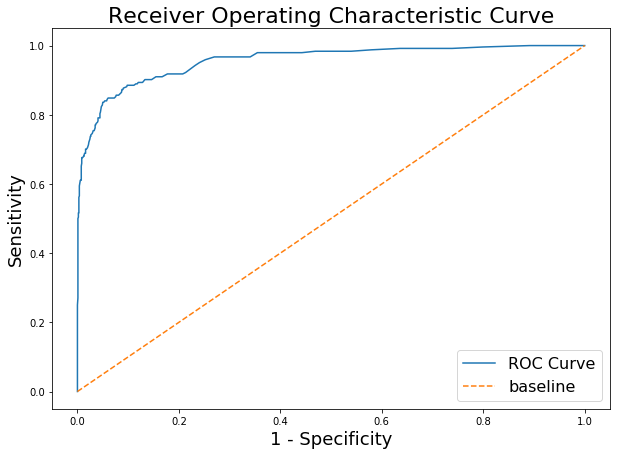

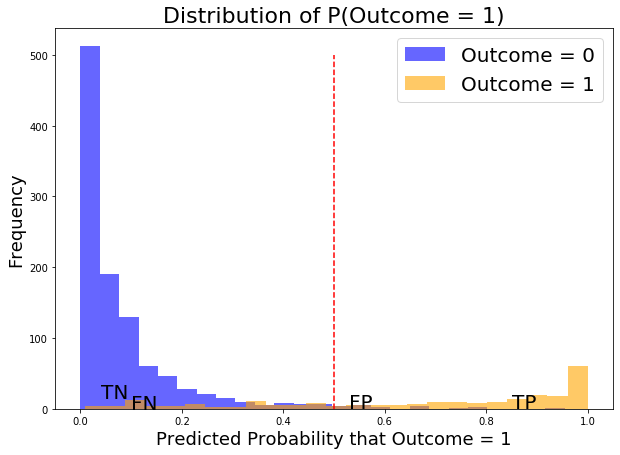

In [559]:
# Logistic Regression on posts
l_features_p = classify(X_post, y, 'logreg', log_vec_p, log_mod_p)

(0.02, 0.98, (1, 1), False, <function stemmer at 0x1a2cc89598>, 'stop_lemm') ('l1', 1)
num_features = 1104
num_features_stroke = 70
num_features_migraine = 41
recall_cv = 0.765380672817072
recall_train = 0.8321964529331515
recall_test = 0.819672131147541


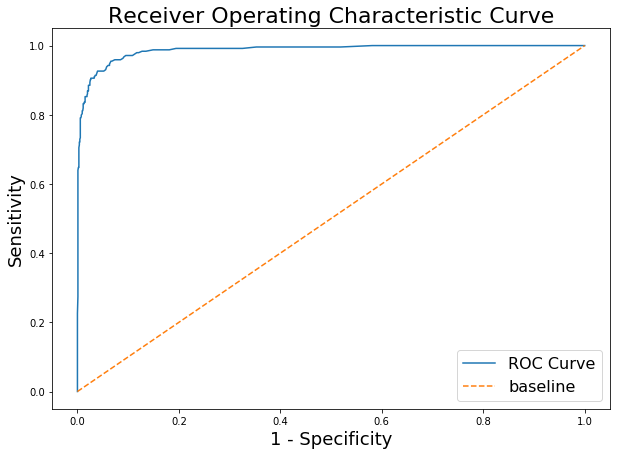

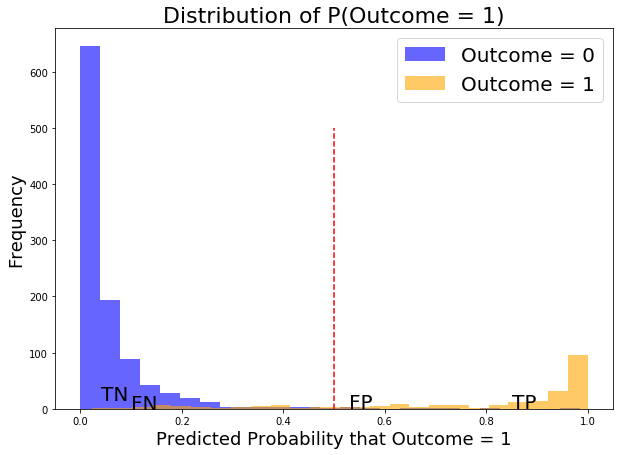

In [557]:
# Logistic Regression on posts and comments
l_features_pc = classify(X_post_comm, y, 'logreg',log_vec_p_c, log_mod_p_c)

(0.01, 0.98, (1, 4), True, <function stemmer at 0x1a2cc89598>, 'stop') (200, 5, None)
num_features = 954
num_features_stroke = 446
num_features_migraine = 0
recall_cv = 0.47479265678874294
recall_train = 0.5361527967257844
recall_test = 0.5163934426229508


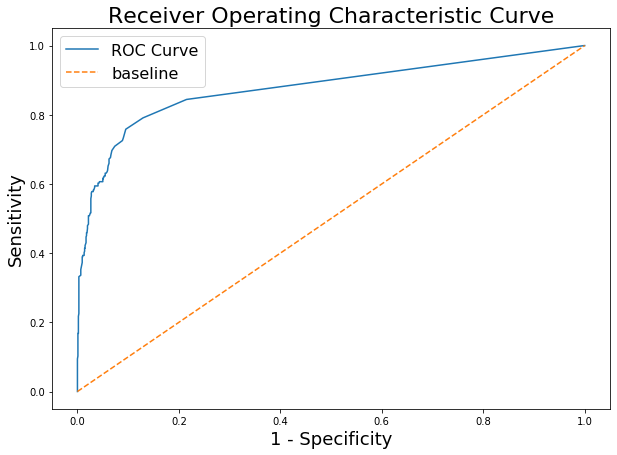

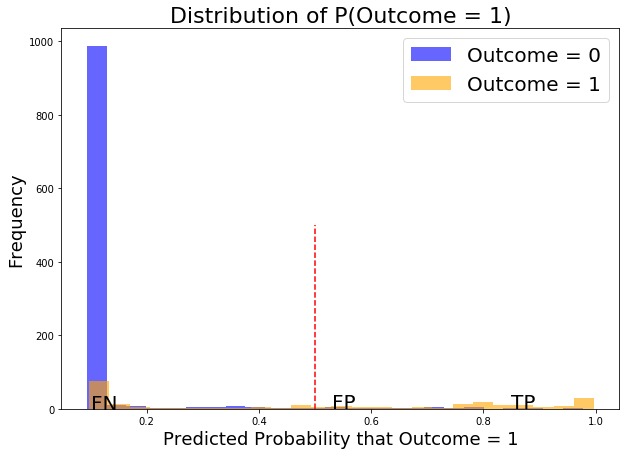

In [565]:
# Random forests on posts
r_features_p = classify(X_post, y, 'ranfor', ran_vec_p, ran_mod_p)

(0.01, 0.98, (1, 1), False, <function stemmer at 0x1a2cc89598>, 'stop_lemm') (100, None, None)
num_features = 1794
num_features_stroke = 1251
num_features_migraine = 0
recall_cv = 0.7721554375174728
recall_train = 1.0
recall_test = 0.7868852459016393


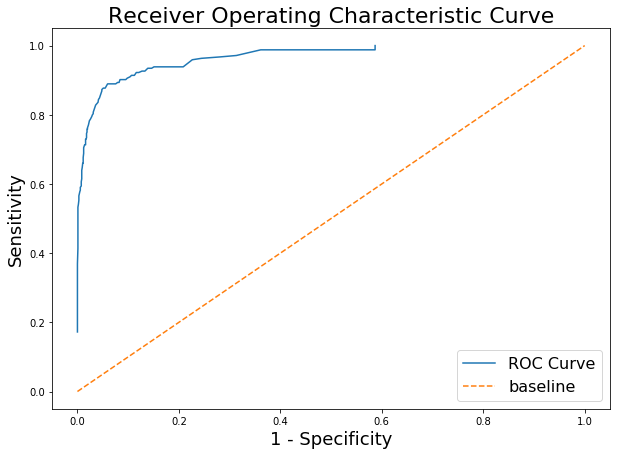

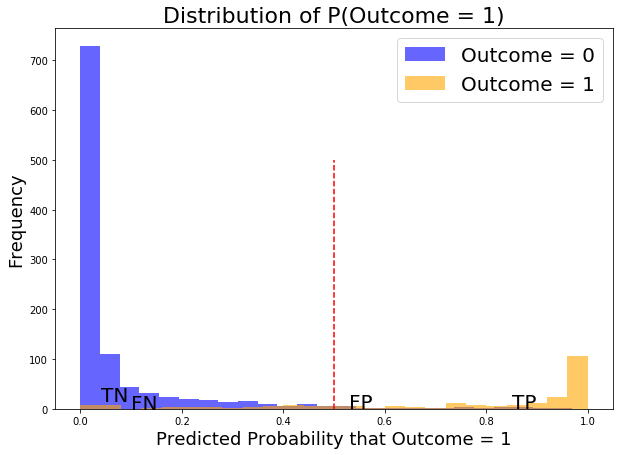

In [567]:
# Random forests on posts and comments
r_features_pc = classify(X_post_comm, y, 'ranfor', ran_vec_p_c, ran_mod_p_c)

(0.01, 0.98, (1, 4), True, <function stemmer at 0x1a2cc89598>, 'stop_stem') (1, False)
num_features = 954
num_features_stroke = 0
num_features_migraine = 954
recall_cv = 0.922234647283571
recall_train = 0.9440654843110505
recall_test = 0.9098360655737705


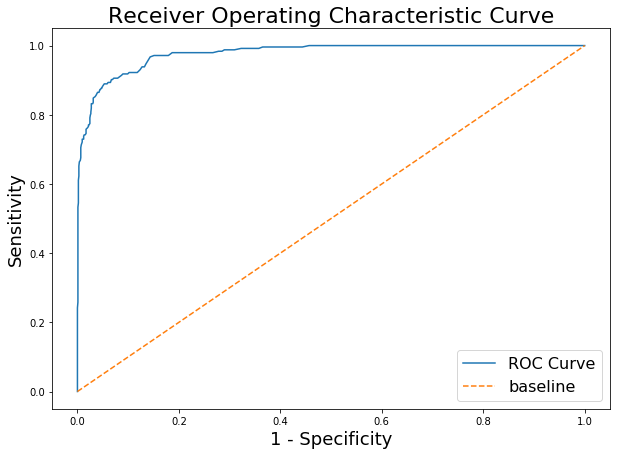

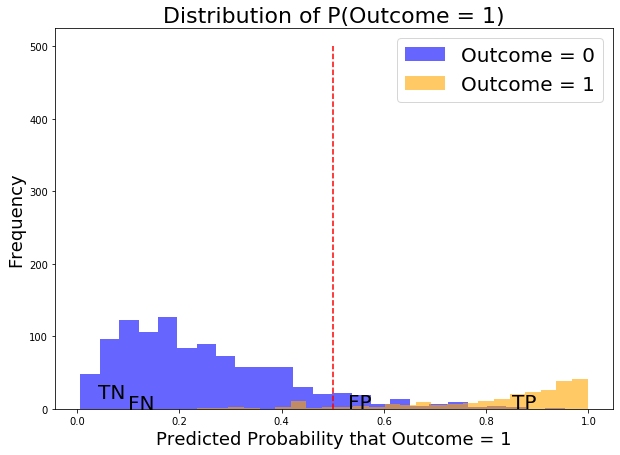

In [568]:
# Multinonial Naive Bayes on posts
n_features_p = classify(X_post, y, 'mnb', nb_vec_p, nb_mod_p)

(0.02, 0.98, (1, 1), True, None, 'stop') (1, False)
num_features = 1104
num_features_stroke = 0
num_features_migraine = 1104
recall_cv = 0.927723418134377
recall_train = 0.937244201909959
recall_test = 0.9467213114754098


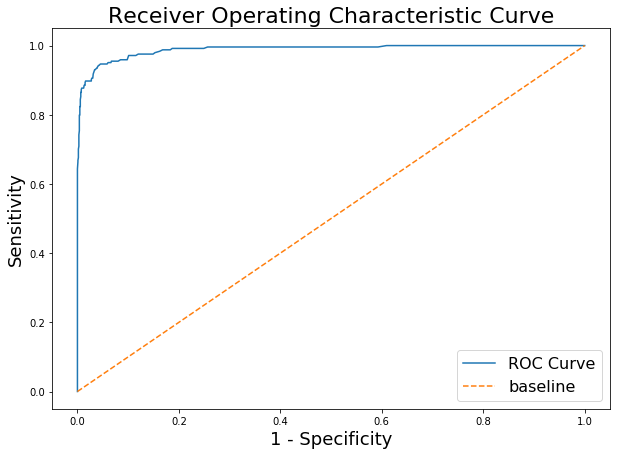

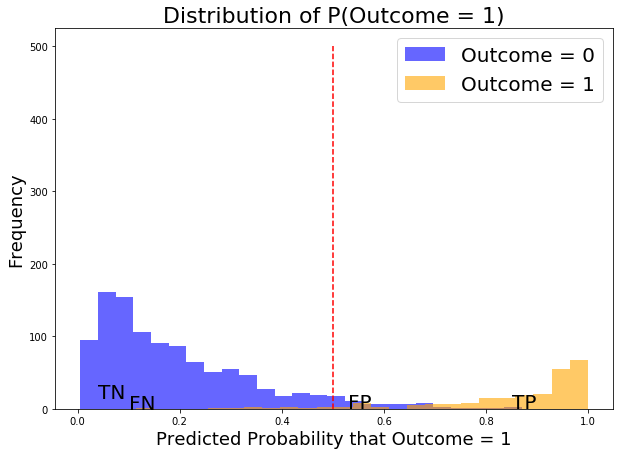

In [569]:
# Multinomial Naive Bayes on posts and comments
n_features_pc = classify(X_post_comm, y, 'mnb', nb_vec_p_c, nb_mod_p_c)

## Analysis of the Bag of Words

#### Most important words based on the coefficient value in the Logistic Regression models

In [581]:
# Top 20 features predicting stroke in using posts
#l_features_p.sort_values(by = 'coefficient', ascending=False).head(20)
l_features_p.head(20)

,word,frequency,coefficient,abs_coef
307,100,12.570582,9.927421,9.927421
26,medicin,21.223580,-7.612090,7.612090
176,experienc,48.802195,7.136695,7.136695
126,mean,22.068329,6.964369,6.964369
396,wrong,14.674043,-6.762707,6.762707
246,nurs,11.287014,6.342301,6.342301
343,big,14.062559,6.306496,6.306496
306,definit,13.761013,6.214092,6.214092
15,worst,30.291057,5.814718,5.814718
53,happen,82.761743,-4.996993,4.996993


In [573]:
# Top 20 features predicting migraine in using posts
l_features_p.sort_values(by = 'coefficient').head(20)

,word,frequency,coefficient,abs_coef
26,medicin,21.223580,-7.612090,7.612090
396,wrong,14.674043,-6.762707,6.762707
53,happen,82.761743,-4.996993,4.996993
162,taken,25.550174,-4.500971,4.500971
311,bodi,41.849041,-4.318966,4.318966
289,typic,11.379877,-3.354414,3.354414
249,memori,18.427618,-3.337546,3.337546
16,post,52.254819,-3.148096,3.148096
360,terrifi,11.289444,-3.050331,3.050331
407,saw,16.845742,-2.646922,2.646922


In [575]:
# Top 20 features predicting stroke using posts+comments
l_features_pc.sort_values(by = 'coefficient', ascending=False).head(20)

,word,frequency,coefficient,abs_coef
781,money,8.701569,13.865900,13.865900
956,highli,5.080054,12.980536,12.980536
791,world,11.321274,12.611050,12.611050
989,sensat,12.742190,11.589488,11.589488
780,death,5.343591,9.076383,9.076383
464,product,14.254831,8.936470,8.936470
238,ct,10.500749,8.125335,8.125335
724,treat,24.767902,6.641189,6.641189
176,told,56.124425,6.545066,6.545066
905,annoy,12.034233,5.679772,5.679772


In [574]:
# Top 20 features predicting migraine using posts+comments
l_features_pc.sort_values(by = 'coefficient').head(20)

,word,frequency,coefficient,abs_coef
1017,sent,8.644161,-9.346109,9.346109
91,mouth,11.261678,-8.270134,8.270134
169,pharmaci,11.166160,-5.542211,5.542211
439,aspirin,9.083939,-5.137384,5.137384
1041,induc,6.054579,-3.805892,3.805892
1044,dog,8.752430,-3.557096,3.557096
541,vertigo,13.417997,-3.493795,3.493795
630,especi,28.203299,-3.420673,3.420673
584,quick,8.764146,-2.740228,2.740228
48,class,14.457787,-2.686127,2.686127


#### Most important words based on the probabilities in the Naive Bayes models

In [578]:
# Top 20 features predicting stroke using posts
n_features_p['probability'] = np.exp(n_features_p['coefficient']) 
n_features_p.sort_values(by = 'probability', ascending=False).head(20)

,word,frequency,coefficient,abs_coef,probability
367,open,17.626074,-5.039653,5.039653,0.006476
423,mg,16.942951,-5.066593,5.066593,0.006304
670,drop,11.136584,-5.067860,5.067860,0.006296
692,pay,12.196251,-5.086694,5.086694,0.006178
451,place,20.837447,-5.093138,5.093138,0.006139
380,immedi,14.276795,-5.100978,5.100978,0.006091
463,test,27.305969,-5.141133,5.141133,0.005851
186,let know,7.892332,-5.181892,5.181892,0.005617
441,tension,22.066556,-5.199736,5.199736,0.005518
948,stab,8.692704,-5.255050,5.255050,0.005221


In [579]:
# Top 20 features predicting migraine using posts
n_features_p['probability'] = np.exp(n_features_p['coefficient']) 
n_features_p.sort_values(by = 'probability').head(20)

,word,frequency,coefficient,abs_coef,probability
860,everyday,14.928039,-8.497479,8.497479,0.000204
462,hospit,41.054413,-8.497479,8.497479,0.000204
870,therapist,8.209026,-8.497479,8.497479,0.000204
19,post,43.465909,-8.497479,8.497479,0.000204
665,slept,8.248487,-8.497479,8.497479,0.000204
461,spent,8.998485,-8.497479,8.497479,0.000204
344,push,9.626283,-8.497479,8.497479,0.000204
664,twice,15.257939,-8.497479,8.497479,0.000204
41,tri,117.335401,-8.497479,8.497479,0.000204
142,12,15.562470,-8.497479,8.497479,0.000204


In [542]:
# Top 20 features predicting stroke using posts+comments
n_features_pc['probability'] = np.exp(n_features_pc['coefficient']) 
n_features_pc.sort_values(by = 'probability', ascending=False).head(20)

,word,frequency,coefficient,abs_coef,probability
388,rel,6.226118,-8.628526,8.628526,0.000179
973,asleep,11.194934,-8.629023,8.629023,0.000179
966,appoint,24.602272,-8.637336,8.637336,0.000177
125,notic,54.439512,-8.649666,8.649666,0.000175
630,especi,28.203299,-8.652973,8.652973,0.000175
627,youtub,8.462654,-8.654268,8.654268,0.000174
706,play,19.754571,-8.654883,8.654883,0.000174
987,nervou,6.797821,-8.657604,8.657604,0.000174
185,otc,7.847670,-8.659115,8.659115,0.000174
916,neurolog,10.035801,-8.662055,8.662055,0.000173


In [543]:
# Top 20 features predicting migraine using posts+comments
n_features_pc['probability'] = np.exp(n_features_pc['coefficient']) 
n_features_pc.sort_values(by = 'probability').head(20)

,word,frequency,coefficient,abs_coef,probability
430,enjoy,11.224652,-8.842650,8.842650,0.000144
328,awak,6.590088,-8.842650,8.842650,0.000144
311,report,5.831149,-8.842650,8.842650,0.000144
1003,tast,10.887690,-8.842650,8.842650,0.000144
1004,compar,7.763319,-8.842650,8.842650,0.000144
944,near,11.151133,-8.842650,8.842650,0.000144
580,20,28.828168,-8.842650,8.842650,0.000144
1019,welcom,5.721155,-8.842650,8.842650,0.000144
1005,color,6.983513,-8.842650,8.842650,0.000144
50,year,230.511184,-8.842650,8.842650,0.000144


#### Most important words based on the feature_importances in the Random Forests models

In [545]:
# Top 20 features using posts
r_features_p.sort_values(by = 'coefficient', ascending=False).head(20)

,word,frequency,coefficient,abs_coef
670,drop,11.136584,0.376449,0.376449
380,immedi,14.276795,0.189473,0.189473
186,let know,7.892332,0.058472,0.058472
812,huge,10.479836,0.056707,0.056707
277,15,19.355925,0.047656,0.047656
669,fight,9.535709,0.036374,0.036374
589,approv,9.538163,0.034284,0.034284
887,reach,7.848474,0.017989,0.017989
188,hey,26.028182,0.016067,0.016067
677,strang,11.582645,0.012828,0.012828


In [546]:
# Top 20 features using posts+comments
r_features_pc.sort_values(by = 'coefficient', ascending=False).head(20)

,word,frequency,coefficient,abs_coef
1274,sinus,10.208725,0.353314,0.353314
1548,english,4.511944,0.081807,0.081807
1288,chocol,7.405800,0.062253,0.062253
1604,joy,4.123947,0.037263,0.037263
596,mental,18.650434,0.022460,0.022460
1650,women,5.852247,0.016051,0.016051
1461,exact,9.278830,0.011537,0.011537
137,best,53.444823,0.010887,0.010887
135,end,44.313460,0.009170,0.009170
733,pin,8.166866,0.008468,0.008468


## Conclusions

1. The number of posts taken from r/stroke is 980, and from r/migraine is 4239. But, the average number of words per observation is 654 and 383 for r/stroke and r/migraine respectively, which balances the number of features contributed from each of the subreddits.
2. Sentiment analysis didn't reveal any significant differences in sentiment between the two subreddits, and was measured as mostly neutral.
3. After testing roughly 17,000 models using Grid Search on Logistic Regression, Random Forests, Naive Bayes, Count Vectorizer and TFIDF Vectorizer, 6 best models were trained with the whole dataset.
4. The Porter Stemmer was used on all the models, since it worked the best with our particular data and models.
4. Models whose had titles+posts+comments received slightly more scores than those which had only titles+posts. This means that comments added value to the classification, and didn't have noise.
5. Multinomial Naive Bayes model had the best sensitivity score of 0.95, and Logistic regression had 0.82.
6. The distribution of probabilities for Naive Bayes is spread more in the middle, whereas the distribution for Logistic Regression is more concentrated on both ends, which means that eventhough Naive Bayes had a better score, Logistic Regression predicted the values with more certainity, which would ensure its good performance on a new dataset.

## Recommendations

1. The Logostic Regression model can be used to predict if anyone is having a stroke based on their post in 'r/DiagnoseMe' subreddit, or a similar discussion forum.
2. A similar model can be used to classify migraines and strokes using medical journals. This model can then be used on clinical notes at a hospital as an initial screening for the prediction of stroke.

## Next Steps

1. Test with Support Vector Machines and KNN models.
2. Further analyse the features and add more stop words.
3. Write a program to continually monitor the posts in 'r/DiagnoseMe' and automatically post replies/comments to posts which are predicted as strokes, suggesting they see a doctor as soon as possible.